In [0]:
!pip3 install torchfusion_utils

In [0]:
from PIL import Image

In [0]:
from torchfusion_utils.fp16 import convertToFP16
from torchfusion_utils.initializers import *
from torchfusion_utils.metrics import Accuracy
from torchfusion_utils.models import load_model,save_model

In [0]:
import time
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [1]:
transforms_train = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize([0.5],
                                                            [0.5])])

transforms_test = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize([0.5],
                                                            [0.5])])

batch_sizes = 32

train_data = datasets.MNIST(root='./train', download=True, transform=transforms_train)
test_data = datasets.MNIST(root='./test', train=False, download=True, transform=transforms_test)

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sizes, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_sizes, shuffle=True)

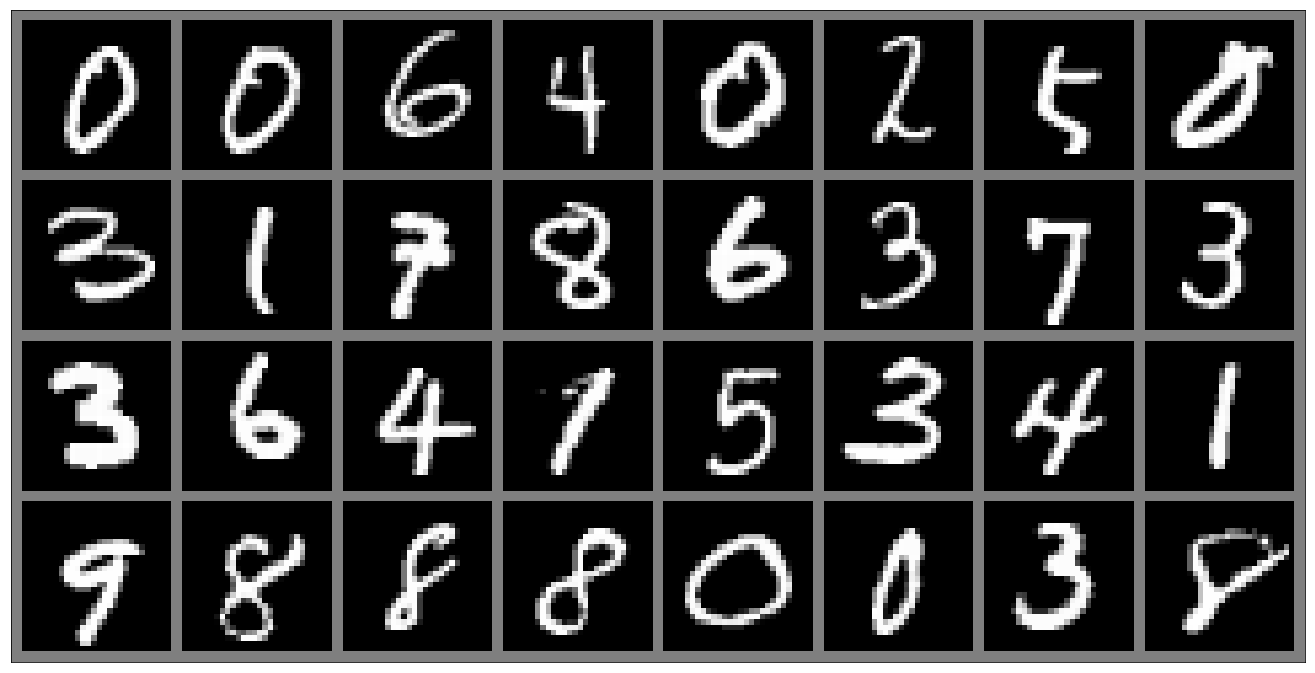

In [0]:
images, labels = next(iter(train_data_loader))

def image_display(image, title=None):
    image = image/2 + 0.5
    numpy_image = image.numpy()
    transposed_numpy_image = np.transpose(numpy_image, (1, 2, 0))
    plt.figure(figsize=(60, 12))
    plt.imshow(transposed_numpy_image)
    plt.yticks([])
    plt.xticks([])
    if title:
        plt.title(title)
    plt.show
    
image_display(torchvision.utils.make_grid(images))

In [0]:
def conv_with_bn(number_in_channels, number_out_channels, kernel_size, stride_size, padding):
    
    layers = []
    layers.append(nn.Conv2d(number_in_channels, number_out_channels, kernel_size=kernel_size, 
                            stride=stride_size, padding=padding, bias=False))
    layers.append(nn.BatchNorm2d(number_out_channels))
    
    return nn.Sequential(*layers)

In [0]:
class Bottle_neck(nn.Module):
    def __init__(self, number_in_channels, number_out_channels, stride):
        
        super(Bottle_neck, self).__init__()
        
                
        self.conv1x1 = conv_with_bn(number_in_channels, int(number_out_channels/4), 1, 1, 0)
        self.conv3x3 = conv_with_bn(int(number_out_channels/4), int(number_out_channels/4), 3, stride, 1)
        self.conv1x1_2 = conv_with_bn(int(number_out_channels/4), number_out_channels, 1, 1, 0)
        
        
        self.conv_identity = nn.Sequential(nn.Conv2d(number_in_channels, 
                                number_out_channels, 1, stride, 0)) if stride == 2 or number_in_channels != number_out_channels else nn.Sequential()
        
        
    def forward(self, x):
        
        previous_output = self.conv_identity(x)
        
        y = F.relu(self.conv1x1(x))
        y = F.relu(self.conv3x3(y))
        y = self.conv1x1_2(y)
        
        y = y + previous_output
        y = F.relu(y)   
        
        return y
    
        

In [0]:
class ResStack(nn.Module):
    def __init__(self, number_in_channels, number_out_channels, stride, num_res_blocks):
        
        super(ResStack,self).__init__()
        
        layers = [Bottle_neck(number_in_channels, number_out_channels, stride)]
        for i in range(num_res_blocks - 1):
            layers.append(Bottle_neck(number_out_channels, number_out_channels, 1))
        
        self.net = nn.Sequential(*layers)
        
        
    def forward(self, x):
        
        return self.net(x)


In [0]:
class ResNet(nn.Module):
    
    def __init__(self):
        super(ResNet, self).__init__()
        
        self.conv7x7 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3)
        self.res_stack_3 = ResStack(64, 256, 1, 3)
        self.res_stack_4 = ResStack(256, 512, 2, 4)
        self.res_stack_6 = ResStack(512, 1024, 2, 6)
        self.res_stack_3_2 = ResStack(1024, 2048, 2, 3)
        
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.global_average_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(2048, len(train_data.classes))

        
        
    def forward(self, x):
        x = F.relu(self.conv7x7(x))
        x = self.maxpool(x)
        x = self.res_stack_3(x)
        x = self.res_stack_4(x)
        x = self.res_stack_6(x)
        x = self.res_stack_3_2(x)
        
        x = self.global_average_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

In [0]:
Model = ResNet() 

Model = Model.cuda()

kaiming_normal_init(Model, types=[nn.Conv2d])

ones_init(Model,types=[nn.BatchNorm2d])

lr = 0.001

criteria = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(Model.parameters(), lr=lr)

Model,optimizer = convertToFP16(Model, optimizer)

milestones = [70, 90]

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
def model_traing_and_validation_loop(Model, n_epochs, save_path):
    
    n_epochs = n_epochs

    saving_criteria_of_model = 0

    training_loss_array = []

    validation_loss_array = []
    
    train_acc = Accuracy()
    
    validation_acc = Accuracy(topK=1)

    for i in range(n_epochs):

        total_test_data = 0

        total_train_data = 0

        correct_test_data = 0

        training_loss = 0

        validation_loss = 0
        
        train_acc.reset()

        for data, target in train_data_loader:

            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()

            predictions = Model(data)

            loss = criteria(predictions, target)
            
            optimizer.backward(loss)

            optimizer.step()

            training_loss += loss.item()*data.size(0)

            train_acc.update(predictions, target)
            
        scheduler.step()

        with torch.no_grad():
            
            validation_acc.reset()
            
            for data, target in test_data_loader:

                data, target = data.to(device), target.to(device)

                predictions = Model(data)
                
                loss = criteria(predictions, target)
                
                validation_acc.update(predictions, target)
                
                total_test_data += target.size(0)

                validation_loss += loss.item()*data.size(0)
                
                
        training_loss = training_loss / len(train_data)
        
        validation_loss = validation_loss / total_test_data

        training_loss_array.append(training_loss)
        
        validation_loss_array.append(validation_loss)


        print(f'{i+1} / {n_epochs} Training loss: {training_loss}, Tran_Accuracy: {train_acc.getValue()}, Validation_loss: {validation_loss}, Validation_Accuracy: {validation_acc.getValue()}')

        if saving_criteria_of_model < validation_acc.getValue():

            torch.save(Model, save_path)
            
            saving_criteria_of_model = validation_acc.getValue()
            
            print('--------------------------Saving Model---------------------------')
         
        
    plt.figure(figsize=(20, 4))
        
    x_axis = (range(n_epochs))
        
    plt.plot(x_axis, training_loss_array, 'r', validation_loss_array, 'b')
        
    plt.title('A gragh of training loss vs validation loss')
        
    plt.legend(['train loss', 'validation loss'])
        
    plt.xlabel('Number of Epochs')
        
    plt.ylabel('Loss')
        
    return Model


In [2]:
n_epochs = 100
model = model_traing_and_validation_loop(Model, n_epochs, 'mnist_numbers.pt')

In [0]:
load_saved_model = torch.load('mnist_numbers.pt')

In [0]:
dummy_input = torch.FloatTensor(1,1,28,28)
dummy_input = dummy_input.to(device)

In [0]:
torch.onnx.export(load_saved_model, dummy_input, 'mnist_numbers.onnx')